<a href="https://colab.research.google.com/github/MyDearGreatTeacher/TF/blob/master/TF_CNN_app2_%EF%BC%A4eepDream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow 's Deep Dream實作


TensorFlow機器學習實戰指南 (美)尼克‧麥克盧爾 機械工業

https://github.com/nfmcclure/tensorflow_cookbook

第8章 卷積神經網路 

8.1 卷積神經網路介紹 

8.2 用TensorFlow實現簡單的CNN 

8.3 用TensorFlow實現進階的CNN 

8.4 再訓練已有的CNN模型 

8.5 用TensorFlow實現模仿大師繪畫 

8.6 用TensorFlow實現DeepDream 


08_Convolutional_Neural_Networks/06_Deepdream/06_deepdream.py'

# 下載相關檔案

In [1]:
!wget https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip 

--2019-05-12 05:39:10--  https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49937555 (48M) [application/zip]
Saving to: ‘inception5h.zip’

inception5h.zip     100%[===================>]  47.62M  67.6MB/s    in 0.7s    

2019-05-12 05:39:11 (67.6 MB/s) - ‘inception5h.zip’ saved [49937555/49937555]



In [2]:
!unzip inception5h.zip

Archive:  inception5h.zip
  inflating: imagenet_comp_graph_label_strings.txt  
  inflating: tensorflow_inception_graph.pb  
  inflating: LICENSE                 


In [3]:
!ls

imagenet_comp_graph_label_strings.txt  sample_data
inception5h.zip			       tensorflow_inception_graph.pb
LICENSE


In [6]:
!wget "https://github.com/nfmcclure/tensorflow_cookbook/blob/master/08_Convolutional_Neural_Networks/06_Deepdream/book_cover.jpg"

--2019-05-12 05:43:28--  https://github.com/nfmcclure/tensorflow_cookbook/blob/master/08_Convolutional_Neural_Networks/06_Deepdream/book_cover.jpg
Resolving github.com (github.com)... 192.30.253.113
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘book_cover.jpg.1’

book_cover.jpg.1        [ <=>                ]  64.17K  --.-KB/s    in 0.03s   

2019-05-12 05:43:28 (2.45 MB/s) - ‘book_cover.jpg.1’ saved [65712]



In [13]:
from google.colab import files
uploaded = files.upload()

Saving book_cover.jpg to book_cover.jpg


In [14]:
!ls

book_cover.jpg			       LICENSE
imagenet_comp_graph_label_strings.txt  sample_data
inception5h.zip			       tensorflow_inception_graph.pb


In [0]:
!rm book*.*

###  確認圖片可以正常顯示

圖像的形狀:
[326 458   3]


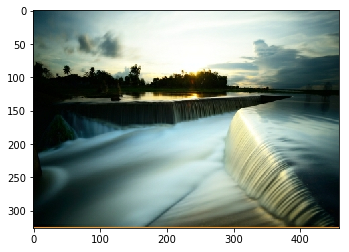

In [15]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import matplotlib.pyplot as plt
#"讀取圖片檔"
image=tf.read_file("book_cover.jpg",'r')
#"將圖片檔解碼為Tensor"
image_tensor=tf.image.decode_jpeg(image)
#"圖像張量的形狀"
shape=tf.shape(image_tensor)
session=tf.Session()
print('圖像的形狀:')
print(session.run(shape))
#"Tensor 轉換為 ndarray"
image_ndarray=image_tensor.eval(session=session)
#"顯示圖片"
plt.imshow(image_ndarray)
plt.show()

# 程式

In [20]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import tensorflow as tf
from io import BytesIO
from tensorflow.python.framework import ops
#ops.reset_default_graph()

# Start a graph session
#graph = tf.Graph()
#sess = tf.InteractiveSession(graph=graph)

#os.chdir('~/Documents/tensorflow/inception-v1-model/')

# Model filename
model_fn = 'tensorflow_inception_graph.pb'

# Load graph parameters
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

# Create placeholder for input
t_input = tf.placeholder(np.float32, name='input')

# Imagenet average bias to subtract off images
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

# Create a list of layers that we can refer to later
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]

# Count how many outputs for each layer
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

# Print count of layers and outputs (features nodes)
print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))

# Picking some internal layer. Note that we use outputs before applying the ReLU nonlinearity
# to have non-zero gradients for features with negative initial activations.
layer = 'mixed4d_3x3_bottleneck_pre_relu'
channel = 30 # picking some feature channel to visualize

# start with a gray image with a little noise
img_noise = np.random.uniform(size=(224,224,3)) + 100.0



Instructions for updating:
Use tf.gfile.GFile.
Number of layers 59
Total number of feature channels: 7548


In [0]:
def showarray(a, fmt='jpeg'):
    # First make sure everything is between 0 and 255
    a = np.uint8(np.clip(a, 0, 1)*255)
    # Pick an in-memory format for image display
    f = BytesIO()
    # Create the in memory image
    PIL.Image.fromarray(a).save(f, fmt)
    # Show image
    plt.imshow(a)


def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)


# The following function returns a function wrapper that will create the placeholder
# inputs of a specified dtype
def tffunc(*argtypes):
    '''Helper that transforms TF-graph generating function into a regular one.
    See "resize" function below.
    '''
    placeholders = list(map(tf.placeholder, argtypes))
    def wrap(f):
        out = f(*placeholders)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(placeholders, args)), session=kw.get('session'))
        return wrapper
    return wrap


# Helper function that uses TF to resize an image
def resize(img, size):
    img = tf.expand_dims(img, 0)
    # Change 'img' size by linear interpolation
    return tf.image.resize_bilinear(img, size)[0, :, :, :]


def calc_grad_tiled(img, t_grad, tile_size=512):
    '''Compute the value of tensor t_grad over the image in a tiled way.
    Random shifts are applied to the image to blur tile boundaries over 
    multiple iterations.'''
    # Pick a subregion square size
    sz = tile_size
    # Get the image height and width
    h, w = img.shape[:2]
    # Get a random shift amount in the x and y direction
    sx, sy = np.random.randint(sz, size=2)
    # Randomly shift the image (roll image) in the x and y directions
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    # Initialize the while image gradient as zeros
    grad = np.zeros_like(img)
    # Now we loop through all the sub-tiles in the image
    for y in range(0, max(h-sz//2, sz),sz):
        for x in range(0, max(w-sz//2, sz),sz):
            # Select the sub image tile
            sub = img_shift[y:y+sz,x:x+sz]
            # Calculate the gradient for the tile
            g = sess.run(t_grad, {t_input:sub})
            # Apply the gradient of the tile to the whole image gradient
            grad[y:y+sz,x:x+sz] = g
    # Return the gradient, undoing the roll operation
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)

def render_deepdream(t_obj, img0=img_noise,
                     iter_n=10, step=1.5, octave_n=4, octave_scale=1.4):
    # defining the optimization objective, the objective is the mean of the feature
    t_score = tf.reduce_mean(t_obj)
    # Our gradients will be defined as changing the t_input to get closer to
    # the values of t_score.  Here, t_score is the mean of the feature we select,
    # and t_input will be the image octave (starting with the last)
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!

    # Store the image
    img = img0
    # Initialize the octave list
    octaves = []
    # Since we stored the image, we need to only calculate n-1 octaves
    for i in range(octave_n-1):
        # Extract the image shape
        hw = img.shape[:2]
        # Resize the image, scale by the octave_scale (resize by linear interpolation)
        lo = resize(img, np.int32(np.float32(hw)/octave_scale))
        # Residual is hi.  Where residual = image - (Resize lo to be hw-shape)
        hi = img-resize(lo, hw)
        # Save the lo image for re-iterating
        img = lo
        # Save the extracted hi-image
        octaves.append(hi)
    
    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            # Start with the last octave
            hi = octaves[-octave]
            #
            img = resize(img, hi.shape[:2])+hi
        for i in range(iter_n):
            # Calculate gradient of the image.
            g = calc_grad_tiled(img, t_grad)
            # Ideally, we would just add the gradient, g, but
            # we want do a forward step size of it ('step'),
            # and divide it by the avg. norm of the gradient, so
            # we are adding a gradient of a certain size each step.
            # Also, to make sure we aren't dividing by zero, we add 1e-7.
            img += g*(step / (np.abs(g).mean()+1e-7))
            print('.',end = ' ')
        showarray(img/255.0)



. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

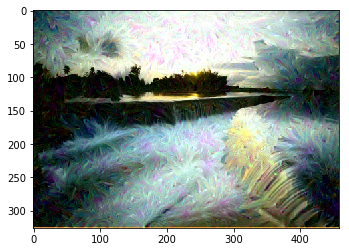

In [22]:
# Run Deep Dream
if __name__=="__main__":
    # Create resize function that has a wrapper that creates specified placeholder types
    resize = tffunc(np.float32, np.int32)(resize)
    
    # Open image
    img0 = PIL.Image.open('book_cover.jpg')
    img0 = np.float32(img0)
    # Show Original Image
    showarray(img0/255.0)

    # Create deep dream
    render_deepdream(T(layer)[:, :, :, channel], img0, iter_n=15)

    sess.close()